# 모델 저장

- 학습한 모델을 저장장치에 파일로 저장하고 나중에 불러와 사용(추가 학습, 예측 서비스) 할 수 있도록 한다. 
- 파이토치는 모델의 파라미터만 저장하는 방법과 모델 구조와 파라미터 모두를 저장하는 두가지 방식을 제공한다.
- 저장 함수
    - `torch.save(저장할 객체, 저장경로)`
- 보통 저장파일의 확장자는 `pt`나 `pth` 를 지정한다.

## 모델 전체 저장하기 및 불러오기

- 저장하기
    - `torch.save(model, 저장경로)`
- 불러오기
    - `load_model = torch.load(저장경로)`
- 저장시 **pickle**을 이용해 직렬화하기 때문에 불어오는 실행환경에도 모델을 저장할 때 사용한 클래스가 있어야 한다.



## 모델의 파라미터만 저장
- 모델을 구성하는 파라미터만 저장한다.
- 모델의 구조는 저장하지 않기 때문에 불러올 때 **모델을 먼저 생성하고 생성한 모델에 불러온 파라미터를 덮어씌운다.**
- 모델의 파라미터는 **state_dict** 형식으로 저장한다.

### state_dict
- 모델의 파라미터 Tensor들을 레이어 단위별로 나누어 저장한 Ordered Dictionary (OrderedDict)
- `모델객체.state_dict()` 메소드를 이용해 조회한다.
- 모델의 state_dict을 조회 후 저장한다.
    - `torch.save(model.state_dict(), "저장경로")`
- 생성된 모델에 읽어온 state_dict를 덮어씌운다.
    - `new_model.load_state_dict(torch.load("state_dict저장경로"))`


In [1]:
import torch
import torch.nn as nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_layer = nn.Linear(784, 64)
        self.out_layer = nn.Linear(64, 10)
    
    def forward(self, X):
        X = torch.flatten(X, start_dim = 1)
        X = nn.ReLU()(self.in_layer(X))
        X = self.out(X)
        return X

In [2]:
sample_model = Network()
sample_model

Network(
  (in_layer): Linear(in_features=784, out_features=64, bias=True)
  (out_layer): Linear(in_features=64, out_features=10, bias=True)
)

In [3]:
# 모델의 state_dict 조회
sd = sample_model.state_dict()  # sd가 저장된다.
print(type(sd))

<class 'collections.OrderedDict'>


In [4]:
sd.keys()  # 각 layer의 parameter(weight, bias)가 조회된다.

odict_keys(['in_layer.weight', 'in_layer.bias', 'out_layer.weight', 'out_layer.bias'])

In [5]:
sd['in_layer.weight'].shape, sd['in_layer.bias'].shape

(torch.Size([64, 784]), torch.Size([64]))

In [6]:
sample_model.parameters()

<generator object Module.parameters at 0x000001925D9D8AC0>

In [7]:
sample_model.in_layer  #  __init__()에 self.in_layer = nn.Linear(784, 64)로 저장된 객체가 반환

Linear(in_features=784, out_features=64, bias=True)

In [8]:
# 개별 조회
sample_model.in_layer.weight
sample_model.out_layer.bias

Parameter containing:
tensor([ 0.0242,  0.0991, -0.0378,  0.0633, -0.0149,  0.0216,  0.0109, -0.0429,
         0.0044,  0.1147], requires_grad=True)

# Checkpoint를 저장 및 불러오기
- 학습이 끝나지 않은 모델을 저장 후 나중에 이어서 학습시킬 경우에는 모델의 구조, 파라미터 뿐만 아니라 optimizer, loss 함수등 학습에 필요한 객체들을 저장해야 한다.
- Dictionary에 필요한 요소들을 key-value 쌍으로 저장후 `torch.save()`를 이용해 저장한다.
```python
# 저장
torch.save({
    'epoch':epoch,
    'model_state_dict':model.state_dict(),
    'optimizer_state_dict':optimizer.state_dict(),
    'loss':train_loss
}, "저장경로")

# 불러오기
model = MyModel()
optimizer = optim.Adam(model.parameter())

checkpoint = torch.load("저장경로")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#### 이어학습
model.train()
#### 추론
model.eval()

```

# 문제 유형별 MLP 네트워크
- MLP(Multi Layer Perceptron)
    - Fully Connected Layer로 구성된 네트워크

# Regression(회귀)

## Boston Housing Dataset
보스턴 주택가격 dataset은 다음과 같은 속성을 바탕으로 해당 타운 주택 가격의 중앙값을 예측하는 문제.
- CRIM: 범죄율
- ZN: 25,000 평방피트당 주거지역 비율
- INDUS: 비소매 상업지구 비율
- CHAS: 찰스강에 인접해 있는지 여부(인접:1, 아니면:0)
- NOX: 일산화질소 농도(단위: 0.1ppm)
- RM: 주택당 방의 수
- AGE: 1940년 이전에 건설된 주택의 비율
- DIS: 5개의 보스턴 직업고용센터와의 거리(가중 평균)
- RAD: 고속도로 접근성
- TAX: 재산세율
- PTRATIO: 학생/교사 비율
- B: 흑인 비율
- LSTAT: 하위 계층 비율
<br><br>
- **Target**
    - MEDV: 타운의 주택가격 중앙값(단위: 1,000달러)

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchinfo

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## Dataset, DataLoader 생성

In [10]:
boston = pd.read_csv('boston_hosing.csv')
boston.shape

X_boston = boston.drop(columns = 'MEDV').values
y_boston = boston['MEDV'].values.reshape(-1, 1)  # 2차원 변경
X_boston.shape, y_boston.shape

((506, 13), (506, 1))

In [11]:
# train / test set 분리 => 회귀임으로 stratify 설정 안함
X_train, X_test, y_train, y_test = train_test_split(X_boston, y_boston, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((404, 13), (102, 13))

In [12]:
# feature scaling
scaler = StandardScaler()
X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype = torch.float32)
X_test_scaled = torch.tensor(scaler.transform(X_test), dtype = torch.float32)

# y를 tensor 타입으로 변환
y_train_tensor = torch.tensor(y_train, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.float32)

In [13]:
# Dataset
boston_train_set = TensorDataset(X_train_scaled, y_train_tensor)
boston_test_set = TensorDataset(X_test_scaled, y_test_tensor)
print(len(boston_train_set), len(boston_test_set))
print(boston_train_set[0])

# DataLoader
boston_train_loader = DataLoader(boston_train_set, batch_size = 200, shuffle = True, drop_last = True)
boston_test_loader = DataLoader(boston_test_set, batch_size = len(boston_test_set))
print(len(boston_train_loader), len(boston_test_loader))  # 1 epoch당 step 수

404 102
(tensor([-0.3726, -0.4996, -0.7049,  3.6645, -0.4249,  0.9357,  0.6937, -0.4372,
        -0.1622, -0.5617, -0.4846,  0.3717, -0.4110]), tensor([26.7000]))
2 1


# 모델 정의

In [14]:
X_boston.shape

(506, 13)

In [15]:
class BostonModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        # 입력 layer => in_feature: input data의 feature개수에 맞춘다.
        self.lr1 = nn.Linear(13, 32)
        
        # hidden layder => in_feature: 앞 layer의 out_feature 개수에 맞춘다.
        self.lr2 = nn.Linear(32, 16)
        
        # output layer => out_feature: 모델의 최종 출력 개수에 맞춘다.(MEDV 1개)
        self.lr3 = nn.Linear(16, 1)

    def forward(self, X):
        # input layer
        out = self.lr1(X)
        out = nn.ReLU()(out)
        
        # hidden layer
        out = self.lr2(out)
        out = nn.ReLU()(out)
        
        # output layer -> 회귀처리 모델에서 output layer에서 활성함수 적용 x
        # 예외 : 출력결과가 특정 활성함수의 출력과 매칭될 경우.
        ## 예를 들면, output의 범위가 0 ~ 1: Logistic 함수 사용
        ##            output의 범위가 -1 ~ 1: tanh 사용
        out = self.lr3(out)
        
        return out

In [16]:
next(iter(boston_train_loader))[0].shape  # 200개에 대한 데이터가 MEDV를 추론함.

torch.Size([200, 13])

In [17]:
boston_model = BostonModel()
torchinfo.summary(boston_model, (200, 13))  # (모델, 입력데이터(batch_size, feature))

Layer (type:depth-idx)                   Output Shape              Param #
BostonModel                              [200, 1]                  --
├─Linear: 1-1                            [200, 32]                 448
├─Linear: 1-2                            [200, 16]                 528
├─Linear: 1-3                            [200, 1]                  17
Total params: 993
Trainable params: 993
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

# 모델 학습

In [18]:
n_epoch = 1000
lr = 0.001

# 결과 저장할 리스트를 생성
train_loss_list = []
val_loss_list = []

# 모델, loss함수(회귀-mse계산), optimizer 정의
boston_model = boston_model.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(boston_model.parameters(), lr = lr)

In [19]:
# 학습: 두단계 - 학습 + 검증
for epoch in range(n_epoch):
    ###################################################
    # 학습단계 - 모델을 train 모드로 변경
    ###################################################
    boston_model.train()
    train_loss = 0.0
    
    for X, y in boston_train_loader:
        # X, y를 device로 이동
        X, y = X.to(device), y.to(device)
        
        # 1. 모델 추정
        pred = boston_model(X)  # 순전파(forward propagation) - forward() 메서드 실행
        
        # 2. loss 계산
        loss = loss_fn(pred, y)  # 추정값이 '먼저' 그리고 정답이 '나중'
        
        # 3. 모델의 파라미터를 업데이트
        ## 3.1 파라미터들의 기울기를 초기화
        optimizer.zero_grad()
        ## 3.2 역전파(back propagation) - 파라미터 기울기를 계산(각각의 grad속성에 저장)
        loss.backward()
        ## 3.3 파라미터 업데이트 => 1step
        optimizer.step()
    
        train_loss += loss.item()
        
    # 평균 loss 구하기
    train_loss /= len(boston_train_loader)  # step 수로 나누기
    
    # 1 epoch 학습 끝. => 1 epoch 학습한 것을 가지고 아래의 검증단계에 들어감
    
    ###################################################
    # 검증단계 - 모델을 평가모드로 변경
    ###################################################
    boston_model.eval()  # evaluation mode로 변환
    val_loss = 0.0
    
    # 역전파를 통한 gradient 계산이 필요없기 때문에 일시적으로 grad_fn을 구하지 않도록 처리.
    with torch.no_grad():
        for X_val, y_val in boston_test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            # 1. 추정
            pred_val = boston_model(X_val)
            # 2. loss 계산
            val_loss += loss_fn(pred_val, y_val).item()
            
        val_loss /= len(boston_test_loader)
        
    # 1 epoch 검증 끝
    
    # 결과 출력
    print(f'[{epoch + 1}/{n_epoch}] train loss: {train_loss:.5f}, val loss: {val_loss:.5f}')
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)   

[1/1000] train loss: 606.24750, val loss: 574.59967
[2/1000] train loss: 593.93195, val loss: 564.97314
[3/1000] train loss: 582.61966, val loss: 553.65619
[4/1000] train loss: 571.54111, val loss: 541.17767
[5/1000] train loss: 558.37988, val loss: 527.50879
[6/1000] train loss: 534.09482, val loss: 512.95410
[7/1000] train loss: 524.59789, val loss: 497.47400
[8/1000] train loss: 507.75020, val loss: 481.20105
[9/1000] train loss: 488.74863, val loss: 464.33896
[10/1000] train loss: 471.60420, val loss: 446.97705
[11/1000] train loss: 451.91350, val loss: 429.40009
[12/1000] train loss: 431.54109, val loss: 411.67908
[13/1000] train loss: 414.43231, val loss: 393.84155
[14/1000] train loss: 393.04822, val loss: 376.17020
[15/1000] train loss: 375.78958, val loss: 358.65353
[16/1000] train loss: 356.89714, val loss: 341.49310
[17/1000] train loss: 332.30133, val loss: 325.00479
[18/1000] train loss: 317.12538, val loss: 309.00146
[19/1000] train loss: 296.52827, val loss: 293.45694
[2

[173/1000] train loss: 19.22946, val loss: 38.68945
[174/1000] train loss: 19.26000, val loss: 38.53271
[175/1000] train loss: 19.06716, val loss: 38.42432
[176/1000] train loss: 19.00059, val loss: 38.30685
[177/1000] train loss: 18.92519, val loss: 38.18249
[178/1000] train loss: 18.75597, val loss: 38.06811
[179/1000] train loss: 18.80000, val loss: 37.96863
[180/1000] train loss: 18.72900, val loss: 37.85033
[181/1000] train loss: 18.56539, val loss: 37.72112
[182/1000] train loss: 18.29455, val loss: 37.55162
[183/1000] train loss: 18.37615, val loss: 37.44656
[184/1000] train loss: 18.32830, val loss: 37.32858
[185/1000] train loss: 18.25981, val loss: 37.19835
[186/1000] train loss: 18.23541, val loss: 37.08773
[187/1000] train loss: 18.10895, val loss: 36.95984
[188/1000] train loss: 17.87949, val loss: 36.83114
[189/1000] train loss: 17.98667, val loss: 36.69182
[190/1000] train loss: 17.47793, val loss: 36.52340
[191/1000] train loss: 17.82166, val loss: 36.40520
[192/1000] t

[360/1000] train loss: 9.15980, val loss: 23.94502
[361/1000] train loss: 9.32865, val loss: 23.99619
[362/1000] train loss: 9.21184, val loss: 23.86588
[363/1000] train loss: 9.31735, val loss: 23.84670
[364/1000] train loss: 9.26867, val loss: 23.79124
[365/1000] train loss: 9.25517, val loss: 23.78699
[366/1000] train loss: 9.25496, val loss: 23.72299
[367/1000] train loss: 9.16207, val loss: 23.64462
[368/1000] train loss: 8.96550, val loss: 23.62063
[369/1000] train loss: 9.22227, val loss: 23.56380
[370/1000] train loss: 9.11016, val loss: 23.56391
[371/1000] train loss: 9.10450, val loss: 23.54087
[372/1000] train loss: 9.14269, val loss: 23.48371
[373/1000] train loss: 9.05178, val loss: 23.43888
[374/1000] train loss: 9.03447, val loss: 23.41840
[375/1000] train loss: 9.01310, val loss: 23.46703
[376/1000] train loss: 9.01831, val loss: 23.38614
[377/1000] train loss: 8.93909, val loss: 23.26634
[378/1000] train loss: 9.00948, val loss: 23.30107
[379/1000] train loss: 8.98365,

[528/1000] train loss: 6.70335, val loss: 20.92365
[529/1000] train loss: 6.72878, val loss: 20.77485
[530/1000] train loss: 6.66884, val loss: 20.79158
[531/1000] train loss: 6.76523, val loss: 20.83726
[532/1000] train loss: 6.61672, val loss: 20.90433
[533/1000] train loss: 6.56145, val loss: 20.72625
[534/1000] train loss: 6.59812, val loss: 20.69142
[535/1000] train loss: 6.70947, val loss: 20.68741
[536/1000] train loss: 6.51257, val loss: 20.81234
[537/1000] train loss: 6.60051, val loss: 20.82360
[538/1000] train loss: 6.58261, val loss: 20.79995
[539/1000] train loss: 6.40485, val loss: 20.89916
[540/1000] train loss: 6.61753, val loss: 20.71894
[541/1000] train loss: 6.56678, val loss: 20.90270
[542/1000] train loss: 6.45527, val loss: 20.82573
[543/1000] train loss: 6.57304, val loss: 20.81121
[544/1000] train loss: 6.49996, val loss: 20.77429
[545/1000] train loss: 6.52524, val loss: 20.63718
[546/1000] train loss: 6.53854, val loss: 20.57436
[547/1000] train loss: 6.39515,

[693/1000] train loss: 5.32039, val loss: 19.57031
[694/1000] train loss: 5.27314, val loss: 19.54573
[695/1000] train loss: 5.34596, val loss: 19.37985
[696/1000] train loss: 5.30073, val loss: 19.57721
[697/1000] train loss: 5.35836, val loss: 19.54816
[698/1000] train loss: 5.43387, val loss: 19.61880
[699/1000] train loss: 5.32477, val loss: 19.37473
[700/1000] train loss: 5.20189, val loss: 19.41683
[701/1000] train loss: 5.44439, val loss: 19.49009
[702/1000] train loss: 5.37788, val loss: 19.62044
[703/1000] train loss: 5.29652, val loss: 19.60528
[704/1000] train loss: 5.25965, val loss: 19.75710
[705/1000] train loss: 5.26965, val loss: 19.60326
[706/1000] train loss: 5.26760, val loss: 19.50073
[707/1000] train loss: 5.23493, val loss: 19.42545
[708/1000] train loss: 5.25613, val loss: 19.55393
[709/1000] train loss: 5.26596, val loss: 19.63674
[710/1000] train loss: 5.23888, val loss: 19.64447
[711/1000] train loss: 5.19784, val loss: 19.43452
[712/1000] train loss: 5.18191,

[858/1000] train loss: 4.46637, val loss: 18.95109
[859/1000] train loss: 4.41232, val loss: 18.85729
[860/1000] train loss: 4.45692, val loss: 19.00338
[861/1000] train loss: 4.40956, val loss: 19.14867
[862/1000] train loss: 4.44918, val loss: 19.06706
[863/1000] train loss: 4.41903, val loss: 18.92680
[864/1000] train loss: 4.51095, val loss: 18.96242
[865/1000] train loss: 4.03824, val loss: 19.02380
[866/1000] train loss: 4.41245, val loss: 18.92746
[867/1000] train loss: 4.44646, val loss: 18.97765
[868/1000] train loss: 4.37227, val loss: 19.09720
[869/1000] train loss: 4.40131, val loss: 18.94051
[870/1000] train loss: 4.39616, val loss: 18.84769
[871/1000] train loss: 4.44092, val loss: 18.91760
[872/1000] train loss: 4.39228, val loss: 18.95735
[873/1000] train loss: 4.40894, val loss: 18.88721
[874/1000] train loss: 4.34209, val loss: 18.91818
[875/1000] train loss: 4.40184, val loss: 18.99997
[876/1000] train loss: 4.35567, val loss: 19.07567
[877/1000] train loss: 4.43374,

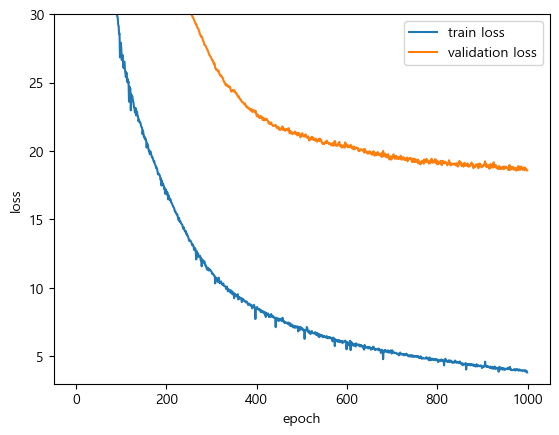

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(n_epoch), train_loss_list, label = 'train loss')
plt.plot(range(n_epoch), val_loss_list, label = 'validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(3, 30)
plt.legend()
plt.show()

# 모델 저장

## 모델 전체 저장 및 불러오기
- 모델구조, 파라미터 저장


In [21]:
# 모델 저장하기
save_path = 'models/boston_model.pt'
torch.save(boston_model, save_path)

In [22]:
# 모델 불러오기
load_boston_model_1 = torch.load(save_path)

In [23]:
torchinfo.summary(load_boston_model_1, (200, 13))

Layer (type:depth-idx)                   Output Shape              Param #
BostonModel                              [200, 1]                  --
├─Linear: 1-1                            [200, 32]                 448
├─Linear: 1-2                            [200, 16]                 528
├─Linear: 1-3                            [200, 1]                  17
Total params: 993
Trainable params: 993
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [24]:
val_loss = 0.0
load_boston_model_1.to(device)
load_boston_model_1.eval()

with torch.no_grad():
    for X_val, y_val in boston_test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        # 1. 추정
        pred_val = load_boston_model_1(X_val)
        # 2. loss 계산
        val_loss += loss_fn(pred_val, y_val).item()

    val_loss /= len(boston_test_loader)

In [25]:
val_loss

18.5853328704834

## state_dict 저장 및 로딩
- 모델 파라미터만 저장

In [26]:
save_path2 = 'models/boston_state_dict_pt'
model_sd = boston_model.state_dict()
# model_sd  # 학습 완료된 parameter

torch.save(model_sd, save_path2)

In [27]:
# state_dict를 로딩
## 1. 모델객체를 생성
load_boston_model_2 = BostonModel().to(device)
## 2. state_dict 불러오기
load_sd = torch.load(save_path2)
## 3. 불러온 state_dict(파라미터들)을 모델에 덮어 씌우기
load_boston_model_2.load_state_dict(load_sd)

# 추정 - 평가모드로 변환
val_loss = 0.0
load_boston_model_2.to(device)
load_boston_model_2.eval()

with torch.no_grad():
    for X_val, y_val in boston_test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        # 1. 추정
        pred_val = load_boston_model_2(X_val)
        # 2. loss 계산
        val_loss += loss_fn(pred_val, y_val).item()

    val_loss /= len(boston_test_loader)
    
val_loss

18.5853328704834

- 마지막 에폭을 저장한 값임으로 validation 결과값이 overfitting되었을 수 도 있다.
- 그래서 validation 결과값이 가장 좋을 때 저장하는 것이 좋다.
- 따라서 학습할 때 전과 비교하면서 성능이 좋을 때 validation 결과값을 저장해야한다.(단, 속도가 느려질 수 있다.)

# 분류 (Classification)

## Fashion MNIST Dataset - 다중분류(Multi-Class Classification) 문제

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 [패션 MNIST](https://github.com/zalandoresearch/fashion-mnist) 데이터셋. 
이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 의류 품목을 나타낸다:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>그림</b> <a href="https://github.com/zalandoresearch/fashion-mnist">패션-MNIST 샘플</a> (Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

이미지는 28x28 크기이며 Gray scale이다. *레이블*(label)은 0에서 9까지의 정수 배열이다. 아래 표는 이미지에 있는 의류의 **클래스**(class)들이다.

<table>
  <tr>
    <th>레이블</th>
    <th>클래스</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trousers</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

In [28]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, datasets
import torchinfo

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [29]:
index_to_class = np.array(['T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
print(index_to_class[0])
class_to_index = {key:value for value, key in enumerate(index_to_class)}
print(class_to_index['T-shirt/top'])

T-shirt/top
0


In [30]:
transform = transforms.Compose([
    transforms.ToTensor(),  # channel first 처리. 0 ~ 1 scaling(= MinMaxScaling), torch.Tensor 변환
    transforms.Normalize(mean = 0.5, std = 0.5)  # 표준화((pixel - mean) / std) 작업. -1 ~ 1 scaling(= StandardScaling)
])

# Dataset Loading
fmnist_trainset = datasets.FashionMNIST(root = 'datasets', train = True, download = True, transform = transform)
fmnist_testset = datasets.FashionMNIST(root = 'datasets', train = False, download = True, transform = transform)

In [31]:
print(fmnist_trainset)
print(fmnist_testset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: datasets
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


In [32]:
fmnist_trainset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [33]:
fmnist_trainset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [34]:
x, y = fmnist_trainset[0]
print(y)
x

9


tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

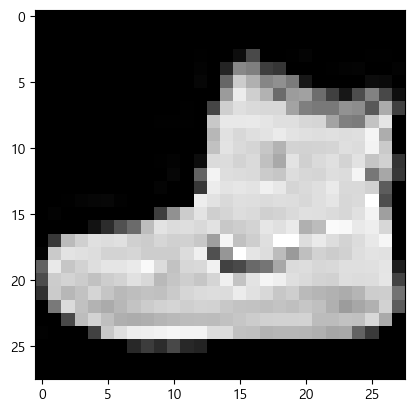

In [35]:
plt.imshow(x[0], cmap ='gray')
plt.show()

In [36]:
# DataLoader 생성
fmnist_train_loader = DataLoader(fmnist_trainset, batch_size = 128, shuffle = True, drop_last = True)
fmnist_test_loader = DataLoader(fmnist_testset, batch_size = 128)

In [37]:
# 모델 정의
class FashionMNISTModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(28 * 28, 2048)
        self.lr2 = nn.Linear(2048, 1024)
        self.lr3 = nn.Linear(1024, 512)
        self.lr4 = nn.Linear(512, 256)
        self.lr5 = nn.Linear(256, 128)
        self.lr6 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)   # out_feature: 10개(class 별 확률)
        
        # torch.flatten() => (batch_size, channel, height, width) -> (batch, c*h*w)
        # nn.Flatten()    => 
        # torch.flatten()과 nn.Flatten()은 같은 개념이나 사용할 때 설정이 다름으로 유의해야 한다.
    def forward(self, X):
        out = nn.Flatten()(X)  # start_dim = 1 => default
        out = nn.ReLU()(self.lr1(out))
        out = nn.ReLU()(self.lr2(out))
        out = nn.ReLU()(self.lr3(out))
        out = nn.ReLU()(self.lr4(out))
        out = nn.ReLU()(self.lr5(out))
        out = nn.ReLU()(self.lr6(out))
        out = self.output(out)
        
        # nn.Softmax()(out) => CrossEntropyLoss()에서 softmax함수가 적용됨으로 사용안함.
        # 다중분류의 output는 Softmax()함수로 계산해서 확률로 만들어서 출력함.
        # 모델에서는 Linear를 통과한 결과를 반환.
        # loss함수인 CrossEntropyLoss()에서 softmax를 적용함.
        return out

In [38]:
f_model = FashionMNISTModel()
f_model

FashionMNISTModel(
  (lr1): Linear(in_features=784, out_features=2048, bias=True)
  (lr2): Linear(in_features=2048, out_features=1024, bias=True)
  (lr3): Linear(in_features=1024, out_features=512, bias=True)
  (lr4): Linear(in_features=512, out_features=256, bias=True)
  (lr5): Linear(in_features=256, out_features=128, bias=True)
  (lr6): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [39]:
torchinfo.summary(f_model, (128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionMNISTModel                        [128, 10]                 --
├─Linear: 1-1                            [128, 2048]               1,607,680
├─Linear: 1-2                            [128, 1024]               2,098,176
├─Linear: 1-3                            [128, 512]                524,800
├─Linear: 1-4                            [128, 256]                131,328
├─Linear: 1-5                            [128, 128]                32,896
├─Linear: 1-6                            [128, 64]                 8,256
├─Linear: 1-7                            [128, 10]                 650
Total params: 4,403,786
Trainable params: 4,403,786
Non-trainable params: 0
Total mult-adds (M): 563.68
Input size (MB): 0.40
Forward/backward pass size (MB): 4.14
Params size (MB): 17.62
Estimated Total Size (MB): 22.16

In [40]:
# 추정
i = torch.ones((2, 1, 28, 28), dtype = torch.float32)
print(i.shape)

y_hat = f_model(i)
print(y_hat.shape)
print(y_hat[0])
print(y_hat[0].sum().item())
print(y_hat[0].argmax(dim = -1).item())  # label

torch.Size([2, 1, 28, 28])
torch.Size([2, 10])
tensor([ 0.0271,  0.0494, -0.1612,  0.1103,  0.0734,  0.1449,  0.1506,  0.0339,
         0.0345,  0.1023], grad_fn=<SelectBackward0>)
0.5652162432670593
6


In [41]:
# 모델이 추정한 결과의 class를 알고 싶을 경우는 softmax를 계산할 필요가 없다.
# 모델의 추정확률을 알고 싶을 경우 softmax를 계산함.
y_hat2 = nn.Softmax(dim = -1)(y_hat[0])
print(y_hat2)
print(y_hat2.sum().item())  # 결과가 1에 가깝다.
print(y_hat2.argmax(dim = -1).item())  # label은 softmax 함수 통과하기 전과 똑같다.

tensor([0.0968, 0.0990, 0.0802, 0.1052, 0.1014, 0.1089, 0.1095, 0.0974, 0.0975,
        0.1043], grad_fn=<SoftmaxBackward0>)
1.0
6


In [84]:
# 학습
import time

# 모델 생성 + device 이동
fmnist_model = FashionMNISTModel().to(device)

# loss -> 다중분류: CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(fmnist_model.parameters(), lr = 0.001)

# 결과저장할 리스트
train_loss_list = []
val_loss_list = []
val_acc_list = []

######################################################
# 학습할 때 이전 epoch보다 성능이 좋을 때 저장함. -> 성능이 개선될 때마다 저장
# 필요한 변수들 정의
######################################################
best_score = torch.inf  # 초기값을 무한으로 지정  ==> 학습중 가장 좋은 평가지표(val_loss)를 저장
save_model_path = 'models/fashion_mnist_best_model.pt'

######################################################
# 조기종료(Eearly Stopping) - 특정 epoch동안 성능 개선이 없으면 학습을 중단.
######################################################
patience = 10  # 성능 개선 여부를 몇 epoch동안 확인할 것인지.
trigger_cnt = 0  # 몇 epoch째 성능 개선을 기다리는지를 저장할 변수

N_EPOCH = 1000
s = time.time()
for epoch in range(N_EPOCH):  # N_EPOCH만큼 학습
    ######################
    # 학습
    ######################
    fmnist_model.train()
    train_loss = 0.0
    for X, y in fmnist_train_loader:
        X, y = X.to(device), y.to(device)
        
        pred = fmnist_model(X)
        loss = loss_fn(pred, y)  # pred: Softmax(), y: OneHotEncoding 처리
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= len(fmnist_train_loader)  # 평균 loss 계산
    # 여기까지가 1 epoch 학습 종료

    ######################
    # 검증
    ######################
    fmnist_model.eval()
    val_loss = 0.0
    val_acc = 0.0
    
    with torch.no_grad():
        for X_val, y_val in fmnist_test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            
            pred_val = fmnist_model(X_val)  # softmax 적용 전 --> loss는 이 값으로 계산
            pred_label = pred_val.argmax(dim = -1)  # ==> accuracy 계산하기 위함
            
            # val - loss 계산
            loss_val = loss_fn(pred_val, y_val)
            val_loss += loss_val.item()
            
            # val - accuracy 계산
            val_acc += torch.sum(pred_label == y_val).item()  # 현 배치에서 맞은 것의 개수
            
        # val_loss, val_acc의 평균
        val_loss /= len(fmnist_test_loader)  # step 수로 나눔
        val_acc /= len(fmnist_test_loader.dataset)  # 총 데이터 개수로 나눔
        
    # 현재 epoch에 대한 학습, 검증 종료 - log 남기기
    print(f'[{epoch + 1} / {N_EPOCH}] train loss: {train_loss:.5f} val loss: {val_loss:.5f} val_accuracy: {val_acc:.5f}')
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    #####################################
    # 조기종료, 모델저장
    # 현 epoch의 val_loss가 best_score보다 개선된 경우(작은 경우)
    #####################################
    if val_loss < best_score:  # 성능 개선되었을 때
        # 저장/조기종료
        print(f'저장: {epoch + 1} epoch - 이전 best_score: {best_score}, 현재 score: {val_loss}')
        best_score = val_loss
        torch.save(fmnist_model, save_model_path)
        trigger_cnt = 0
        
    else:
        # 저장안하기 / trigger_cnt 증가 => 조기종료
        trigger_cnt += 1
        if patience == trigger_cnt:
            print(f'조기종료: epoch - {epoch + 1}, {best_score:.5f}에서 개선이 안됨.')
            break
    
e = time.time()
print(f'학습에 걸린 시간: {e - s}초')

[1 / 1000] train loss: 0.58862 val loss: 0.45202 val_accuracy: 0.83900
저장: 1 epoch - 이전 best_score: inf, 현재 score: 0.45201538465445557
[2 / 1000] train loss: 0.40346 val loss: 0.40907 val_accuracy: 0.85240
저장: 2 epoch - 이전 best_score: 0.45201538465445557, 현재 score: 0.4090650762561001
[3 / 1000] train loss: 0.35796 val loss: 0.39002 val_accuracy: 0.86040
저장: 3 epoch - 이전 best_score: 0.4090650762561001, 현재 score: 0.3900228105013884
[4 / 1000] train loss: 0.33094 val loss: 0.38394 val_accuracy: 0.86160
저장: 4 epoch - 이전 best_score: 0.3900228105013884, 현재 score: 0.3839438344481625
[5 / 1000] train loss: 0.30544 val loss: 0.37135 val_accuracy: 0.86670
저장: 5 epoch - 이전 best_score: 0.3839438344481625, 현재 score: 0.371348441778859
[6 / 1000] train loss: 0.28959 val loss: 0.35993 val_accuracy: 0.87630
저장: 6 epoch - 이전 best_score: 0.371348441778859, 현재 score: 0.35993222628213184
[7 / 1000] train loss: 0.27183 val loss: 0.34571 val_accuracy: 0.88220
저장: 7 epoch - 이전 best_score: 0.35993222628213184,

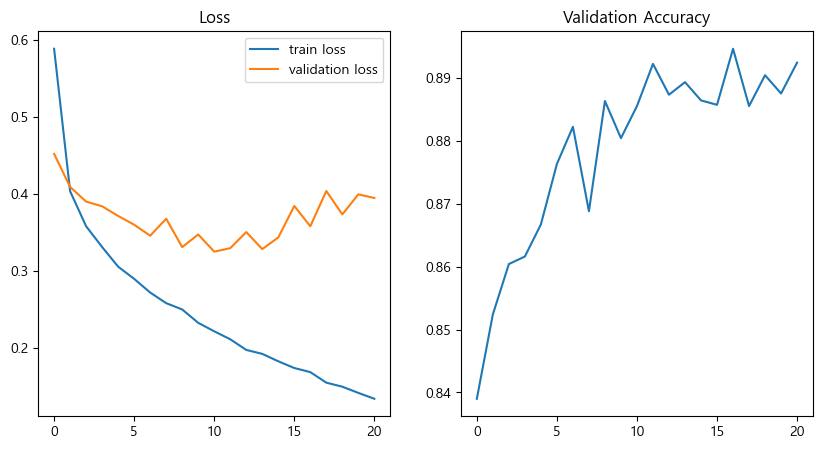

In [85]:
# 결과 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label = 'train loss')
plt.plot(val_loss_list, label = 'validation loss')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc_list)
plt.title("Validation Accuracy")
plt.show()

In [86]:
fmnist_load_model = torch.load(save_model_path)

In [87]:
val_loss, val_acc = 0., 0.

with torch.no_grad():
        for X_val, y_val in fmnist_test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            
            pred_val = fmnist_load_model(X_val)  # softmax 적용 전 --> loss는 이 값으로 계산
            pred_label = pred_val.argmax(dim = -1)  # ==> accuracy 계산하기 위함
            
            # val -> loss 계산
            loss_val = loss_fn(pred_val, y_val)
            val_loss += loss_val.item()
            
            # val -> accuracy 계산
            val_acc += torch.sum(pred_label == y_val).item()  # 현 배치에서 맞은 것의 개수
            
        # val_loss, val_acc의 평균
        val_loss /= len(fmnist_test_loader)  # step 수로 나눔
        val_acc /= len(fmnist_test_loader.dataset)  # 총 데이터 개수로 나눔   

In [88]:
val_loss, val_acc

(0.3249688531401791, 0.8855)

## 위스콘신 유방암 데이터셋 - 이진분류(Binary Classification) 문제

- **이진 분류 문제 처리 모델의 두가지 방법**
    1. positive(1)일 확률을 출력하도록 구현
        - output layer: units=1, activation='sigmoid'
        - loss: binary_crossentropy
    2. negative(0)일 확률과 positive(1)일 확률을 출력하도록 구현 => 다중분류 처리 방식으로 해결
        - output layer: units=2, activation='softmax', y(정답)은 one hot encoding 처리
        - loss: categorical_crossentropy
        
- 위스콘신 대학교에서 제공한 종양의 악성/양성여부 분류를 위한 데이터셋
- Feature
    - 종양에 대한 다양한 측정값들
- Target의 class
    - 0 - malignant(악성종양)
    - 1 - benign(양성종양)

In [166]:
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y = True)
y = y.reshape(-1, 1)  # 2차원으로 변경 ==> 모델 출력 shape과 맞춰준다.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 0)

# scaling
scaler = StandardScaler()
X_train_tensor = torch.tensor(scaler.fit_transform(X_train), dtype = torch.float32)
X_test_tensor = torch.tensor(scaler.transform(X_test), dtype = torch.float32)

y_train_tensor = torch.tensor(y_train, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.float32)

In [167]:
# Dataset - 데이터셋이 Tensor 객체로 메모리에 loading된 경우
wb_train_set = TensorDataset(X_train_tensor, y_train_tensor)
wb_test_set = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoader
wb_train_loader = DataLoader(wb_train_set, batch_size = len(wb_train_set), shuffle = True, drop_last = True)
wb_test_loader = DataLoader(wb_test_set, batch_size = len(wb_test_set))

In [168]:
x, y = next(iter(wb_train_loader))
x.shape, y.shape

(torch.Size([426, 30]), torch.Size([426, 1]))

In [169]:
x.mean(dim = 0), x.std(dim = 0)

(tensor([-2.2387e-09,  7.8354e-09, -4.4773e-09,  2.2387e-09,  1.1193e-09,
         -2.2387e-09,  6.7160e-09, -6.1563e-09, -8.9547e-09,  1.6790e-09,
          6.7160e-09, -7.2757e-09, -6.7160e-09,  0.0000e+00,  6.7160e-09,
         -1.1193e-08,  2.2387e-09,  6.7160e-09, -5.5967e-09,  0.0000e+00,
         -4.4773e-09,  5.5967e-09,  7.2757e-09,  5.5967e-09,  0.0000e+00,
          8.9547e-09,  6.1563e-09, -2.2387e-09, -7.8354e-09, -1.1193e-09]),
 tensor([1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012,
         1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012,
         1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012,
         1.0012, 1.0012, 1.0012]))

In [170]:
# 악성 / 양성 분류
index_to_class = ['악성종양', '양성종양']
class_to_index = {'악성종양': 0, '양성종양': 1}

In [171]:
# 모델 정의
class BreastCancerModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.lr1 = nn.Linear(30, 32)
        self.lr2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)  # 출력 - 값 1개(positive의 확률을 출력)
        
    def forward(self, X):
        out = nn.ReLU()(self.lr1(X))
        out = nn.ReLU()(self.lr2(out))
        out = self.output(out)
        # 2진 분류 -> positive 확률을 출력 => output의 출력결과를 logistic 함수에 입력
        out = nn.Sigmoid()(out)
    
        return out  

In [172]:
bc_model_tmp = BreastCancerModel()

# 모델 test
tmp_x = torch.ones(5, 30)
y_tmp = bc_model_tmp(tmp_x)
y_tmp  # sigmoid함수를 통해야 아래와 같이 확률로 나옴.

tensor([[0.5079],
        [0.5079],
        [0.5079],
        [0.5079],
        [0.5079]], grad_fn=<SigmoidBackward0>)

In [173]:
# 학습처리
N_EPOCH = 500
train_loss_list, val_loss_list, val_acc_list = [], [], []

model = BreastCancerModel().to(device)
loss_fn = nn.BCELoss()  # 이진분류 - postive 확률 출력 모델의 loss-binary cross entorpy loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# early stopping, 모델 저장을 위한 변수
best_score = torch.inf
save_model_path_bc = 'models/breast_cancer_best_model.pt'

patience = 10  # 개선될때까지 몇 번 기다릴지
trigger_cnt = 0  # 몇 번째 기다렸는지

s= time.time()
for epoch in range(N_EPOCH):
    ## 학습
    model.train()
    train_loss = 0.0
    for X, y in wb_train_loader:
        X, y = X.to(device), y.to(device)
        
        # 추정
        pred = model(X)  # positive 확률 ==> loss 계산
        loss = loss_fn(pred, y)
        
        # 파라미터 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    # 학습종료 -> train loss 평균
    train_loss /= len(wb_train_loader)
    
    ## 검증
    model.eval()
    
    val_loss, val_acc = 0., 0.
    with torch.no_grad():
        for X_val, y_val in wb_test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            
            # 추정
            pred_val = model(X_val)  # postive의 확률 => 0.xx 형태로 반환 ==> loss 계산할 때 사용
            
            # 0.5 기준으로 크면 양성, bool type(True / False)을 int type(1, 0)로 변환
            pred_label = (pred_val >= 0.5).type(torch.int32)  # ==> accuracy 계산할 때 사용
            
            loss_val = loss_fn(pred_val, y_val)
            val_loss += loss_val.item()
            val_acc += torch.sum(pred_label == y_val).item()
            
        val_loss /= len(wb_test_loader)
        val_acc /= len(wb_test_loader.dataset)
        
    # 현재 epoch에 대한 학습/검증 종료
    # 로그출력
    print(f'[{epoch + 1}/{N_EPOCH}] train loss: {train_loss}, val loss: {val_loss}, val accuracy: {val_acc}')
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    # early stopping, model 저장 처리
    if val_loss < best_score:  # 성능개선되었다면
        print(f'{epoch + 1} epoch에서 저장. 이전 score: {best_score}, 현재 score: {val_loss}')
        best_score = val_loss
        torch.save(model, save_model_path_bc)
        trigger_cnt = 0
    else:  # 성능이 개선 안되었다면
        trigger_cnt += 1
        if patience == trigger_cnt:  # 조기 종료
            print(f'{epoch} epoch에서 종료. {best_score}에서 성능이 개선되지 않음')
            break

e = time.time()
print(f'걸린 시간: {e-s}초')

[1/500] train loss: 0.7176641821861267, val loss: 0.7198870778083801, val accuracy: 0.3706293706293706
1 epoch에서 저장. 이전 score: inf, 현재 score: 0.7198870778083801
[2/500] train loss: 0.7125005125999451, val loss: 0.7150562405586243, val accuracy: 0.3706293706293706
2 epoch에서 저장. 이전 score: 0.7198870778083801, 현재 score: 0.7150562405586243
[3/500] train loss: 0.7074509263038635, val loss: 0.7103273272514343, val accuracy: 0.3706293706293706
3 epoch에서 저장. 이전 score: 0.7150562405586243, 현재 score: 0.7103273272514343
[4/500] train loss: 0.7024427056312561, val loss: 0.7056093215942383, val accuracy: 0.3706293706293706
4 epoch에서 저장. 이전 score: 0.7103273272514343, 현재 score: 0.7056093215942383
[5/500] train loss: 0.6974994540214539, val loss: 0.7009541392326355, val accuracy: 0.3706293706293706
5 epoch에서 저장. 이전 score: 0.7056093215942383, 현재 score: 0.7009541392326355
[6/500] train loss: 0.6925881505012512, val loss: 0.6963651180267334, val accuracy: 0.3706293706293706
6 epoch에서 저장. 이전 score: 0.700954

[71/500] train loss: 0.2558855712413788, val loss: 0.28896892070770264, val accuracy: 0.9020979020979021
71 epoch에서 저장. 이전 score: 0.29541000723838806, 현재 score: 0.28896892070770264
[72/500] train loss: 0.24917122721672058, val loss: 0.28269121050834656, val accuracy: 0.9020979020979021
72 epoch에서 저장. 이전 score: 0.28896892070770264, 현재 score: 0.28269121050834656
[73/500] train loss: 0.24261526763439178, val loss: 0.2765768766403198, val accuracy: 0.9090909090909091
73 epoch에서 저장. 이전 score: 0.28269121050834656, 현재 score: 0.2765768766403198
[74/500] train loss: 0.23620431125164032, val loss: 0.2706432044506073, val accuracy: 0.9090909090909091
74 epoch에서 저장. 이전 score: 0.2765768766403198, 현재 score: 0.2706432044506073
[75/500] train loss: 0.22995752096176147, val loss: 0.2648622691631317, val accuracy: 0.9090909090909091
75 epoch에서 저장. 이전 score: 0.2706432044506073, 현재 score: 0.2648622691631317
[76/500] train loss: 0.22387245297431946, val loss: 0.25924041867256165, val accuracy: 0.9160839160

[137/500] train loss: 0.06965713202953339, val loss: 0.1243937686085701, val accuracy: 0.958041958041958
137 epoch에서 저장. 이전 score: 0.12498452514410019, 현재 score: 0.1243937686085701
[138/500] train loss: 0.06888829171657562, val loss: 0.12383238226175308, val accuracy: 0.958041958041958
138 epoch에서 저장. 이전 score: 0.1243937686085701, 현재 score: 0.12383238226175308
[139/500] train loss: 0.06813915073871613, val loss: 0.12328445166349411, val accuracy: 0.958041958041958
139 epoch에서 저장. 이전 score: 0.12383238226175308, 현재 score: 0.12328445166349411
[140/500] train loss: 0.06740957498550415, val loss: 0.12275967746973038, val accuracy: 0.958041958041958
140 epoch에서 저장. 이전 score: 0.12328445166349411, 현재 score: 0.12275967746973038
[141/500] train loss: 0.06669912487268448, val loss: 0.12224334478378296, val accuracy: 0.958041958041958
141 epoch에서 저장. 이전 score: 0.12275967746973038, 현재 score: 0.12224334478378296
[142/500] train loss: 0.06600907444953918, val loss: 0.12174209207296371, val accuracy: 

[183/500] train loss: 0.04814298450946808, val loss: 0.11017416417598724, val accuracy: 0.958041958041958
183 epoch에서 저장. 이전 score: 0.11029408127069473, 현재 score: 0.11017416417598724
[184/500] train loss: 0.04786420986056328, val loss: 0.11006103456020355, val accuracy: 0.958041958041958
184 epoch에서 저장. 이전 score: 0.11017416417598724, 현재 score: 0.11006103456020355
[185/500] train loss: 0.04758943244814873, val loss: 0.1099485531449318, val accuracy: 0.958041958041958
185 epoch에서 저장. 이전 score: 0.11006103456020355, 현재 score: 0.1099485531449318
[186/500] train loss: 0.04731929302215576, val loss: 0.10983853787183762, val accuracy: 0.958041958041958
186 epoch에서 저장. 이전 score: 0.1099485531449318, 현재 score: 0.10983853787183762
[187/500] train loss: 0.04705462232232094, val loss: 0.1097356528043747, val accuracy: 0.958041958041958
187 epoch에서 저장. 이전 score: 0.10983853787183762, 현재 score: 0.1097356528043747
[188/500] train loss: 0.04679351672530174, val loss: 0.10963736474514008, val accuracy: 0.

[238/500] train loss: 0.03672461956739426, val loss: 0.10513491928577423, val accuracy: 0.965034965034965
238 epoch에서 저장. 이전 score: 0.10524642467498779, 현재 score: 0.10513491928577423
[239/500] train loss: 0.03655858710408211, val loss: 0.10502185672521591, val accuracy: 0.965034965034965
239 epoch에서 저장. 이전 score: 0.10513491928577423, 현재 score: 0.10502185672521591
[240/500] train loss: 0.036393605172634125, val loss: 0.10490702837705612, val accuracy: 0.965034965034965
240 epoch에서 저장. 이전 score: 0.10502185672521591, 현재 score: 0.10490702837705612
[241/500] train loss: 0.036230072379112244, val loss: 0.10479319840669632, val accuracy: 0.965034965034965
241 epoch에서 저장. 이전 score: 0.10490702837705612, 현재 score: 0.10479319840669632
[242/500] train loss: 0.03606724739074707, val loss: 0.10468017309904099, val accuracy: 0.965034965034965
242 epoch에서 저장. 이전 score: 0.10479319840669632, 현재 score: 0.10468017309904099
[243/500] train loss: 0.03590504825115204, val loss: 0.10456966608762741, val accur

[302/500] train loss: 0.02760441228747368, val loss: 0.10056021809577942, val accuracy: 0.965034965034965
302 epoch에서 저장. 이전 score: 0.10061461478471756, 현재 score: 0.10056021809577942
[303/500] train loss: 0.027483271434903145, val loss: 0.10050281137228012, val accuracy: 0.965034965034965
303 epoch에서 저장. 이전 score: 0.10056021809577942, 현재 score: 0.10050281137228012
[304/500] train loss: 0.027362290769815445, val loss: 0.10045913606882095, val accuracy: 0.965034965034965
304 epoch에서 저장. 이전 score: 0.10050281137228012, 현재 score: 0.10045913606882095
[305/500] train loss: 0.0272427499294281, val loss: 0.10041501373052597, val accuracy: 0.965034965034965
305 epoch에서 저장. 이전 score: 0.10045913606882095, 현재 score: 0.10041501373052597
[306/500] train loss: 0.027123158797621727, val loss: 0.10037398338317871, val accuracy: 0.965034965034965
306 epoch에서 저장. 이전 score: 0.10041501373052597, 현재 score: 0.10037398338317871
[307/500] train loss: 0.027004670351743698, val loss: 0.10033386945724487, val accu

In [79]:
torchinfo.summary(model, (100, 30))

Layer (type:depth-idx)                   Output Shape              Param #
BreastCancerModel                        [100, 1]                  --
├─Linear: 1-1                            [100, 32]                 992
├─Linear: 1-2                            [100, 16]                 528
├─Linear: 1-3                            [100, 1]                  17
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
Total mult-adds (M): 0.15
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.01
Estimated Total Size (MB): 0.06

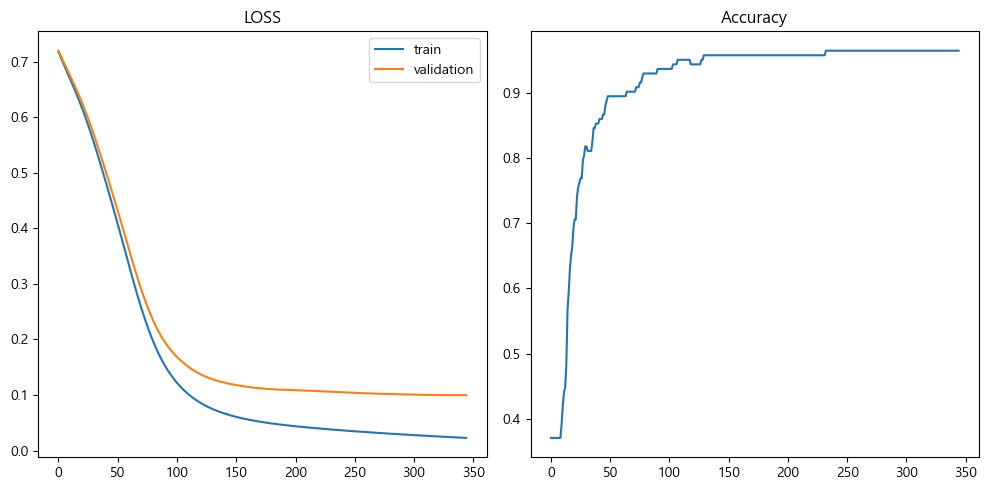

In [174]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.title('LOSS')
plt.plot(train_loss_list, label = 'train')
plt.plot(val_loss_list, label = 'validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(val_acc_list)

plt.tight_layout()
plt.show()

In [175]:
# 평가
load_model = torch.load(save_model_path_bc)
load_model

BreastCancerModel(
  (lr1): Linear(in_features=30, out_features=32, bias=True)
  (lr2): Linear(in_features=32, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)

In [176]:
val_loss, val_acc = 0., 0.
with torch.no_grad():
    for X_val, y_val in wb_test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)

        # 추정
        pred_val = load_model(X_val)  # postive의 확률 => 0.xx 형태로 반환 ==> loss 계산할 때 사용

        # 0.5 기준으로 크면 양성, bool type(True / False)을 int type(1, 0)로 변환
        pred_label = (pred_val >= 0.5).type(torch.int32)  # ==> accuracy 계산할 때 사용

        loss_val = loss_fn(pred_val, y_val)
        val_loss += loss_val.item()
        val_acc += torch.sum(pred_label == y_val).item()

    val_loss /= len(wb_test_loader)
    val_acc /= len(wb_test_loader.dataset)

In [177]:
val_loss, val_acc

(0.09970857203006744, 0.965034965034965)

In [ ]:
#####################################################

In [178]:
from module import train

In [186]:
train.fit?

In [180]:
# 이진 분류
model = BreastCancerModel()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [181]:
result = train.fit(wb_train_loader,
                   wb_test_loader,
                   model,
                   loss_fn,
                   optimizer,
                   100,
                   save_best_model = True,
                   save_model_path = 'models/bc_model.pt',
                   patience = 5,
                   device = device)

Epoch[1/100] - Train loss: 0.70824 Train Accucracy: 0.26526 || Validation Loss: 0.70639 Validation Accuracy: 0.25874
저장: 1 - 이전 : inf, 현재: 0.706386387348175
Epoch[2/100] - Train loss: 0.70139 Train Accucracy: 0.34272 || Validation Loss: 0.69991 Validation Accuracy: 0.31469
저장: 2 - 이전 : 0.706386387348175, 현재: 0.6999145746231079
Epoch[3/100] - Train loss: 0.69463 Train Accucracy: 0.46948 || Validation Loss: 0.69361 Validation Accuracy: 0.46853
저장: 3 - 이전 : 0.6999145746231079, 현재: 0.6936080455780029
Epoch[4/100] - Train loss: 0.68794 Train Accucracy: 0.60094 || Validation Loss: 0.68742 Validation Accuracy: 0.60839
저장: 4 - 이전 : 0.6936080455780029, 현재: 0.6874219179153442
Epoch[5/100] - Train loss: 0.68137 Train Accucracy: 0.73709 || Validation Loss: 0.68130 Validation Accuracy: 0.69930
저장: 5 - 이전 : 0.6874219179153442, 현재: 0.6813010573387146
Epoch[6/100] - Train loss: 0.67494 Train Accucracy: 0.79577 || Validation Loss: 0.67534 Validation Accuracy: 0.75524
저장: 6 - 이전 : 0.6813010573387146, 현재

Epoch[38/100] - Train loss: 0.41951 Train Accucracy: 0.94601 || Validation Loss: 0.43780 Validation Accuracy: 0.93007
저장: 38 - 이전 : 0.4478628635406494, 현재: 0.4377982020378113
Epoch[39/100] - Train loss: 0.40867 Train Accucracy: 0.94601 || Validation Loss: 0.42771 Validation Accuracy: 0.93007
저장: 39 - 이전 : 0.4377982020378113, 현재: 0.4277065396308899
Epoch[40/100] - Train loss: 0.39783 Train Accucracy: 0.94601 || Validation Loss: 0.41764 Validation Accuracy: 0.93007
저장: 40 - 이전 : 0.4277065396308899, 현재: 0.4176439940929413
Epoch[41/100] - Train loss: 0.38702 Train Accucracy: 0.94601 || Validation Loss: 0.40764 Validation Accuracy: 0.93007
저장: 41 - 이전 : 0.4176439940929413, 현재: 0.4076385498046875
Epoch[42/100] - Train loss: 0.37626 Train Accucracy: 0.94601 || Validation Loss: 0.39770 Validation Accuracy: 0.93007
저장: 42 - 이전 : 0.4076385498046875, 현재: 0.397696852684021
Epoch[43/100] - Train loss: 0.36559 Train Accucracy: 0.94601 || Validation Loss: 0.38783 Validation Accuracy: 0.93007
저장: 43 -

Epoch[74/100] - Train loss: 0.14751 Train Accucracy: 0.97183 || Validation Loss: 0.18175 Validation Accuracy: 0.94406
저장: 74 - 이전 : 0.18525227904319763, 현재: 0.18175268173217773
Epoch[75/100] - Train loss: 0.14399 Train Accucracy: 0.97183 || Validation Loss: 0.17840 Validation Accuracy: 0.94406
저장: 75 - 이전 : 0.18175268173217773, 현재: 0.17840033769607544
Epoch[76/100] - Train loss: 0.14063 Train Accucracy: 0.97183 || Validation Loss: 0.17520 Validation Accuracy: 0.94406
저장: 76 - 이전 : 0.17840033769607544, 현재: 0.1751953661441803
Epoch[77/100] - Train loss: 0.13740 Train Accucracy: 0.97183 || Validation Loss: 0.17214 Validation Accuracy: 0.94406
저장: 77 - 이전 : 0.1751953661441803, 현재: 0.17213597893714905
Epoch[78/100] - Train loss: 0.13430 Train Accucracy: 0.97183 || Validation Loss: 0.16919 Validation Accuracy: 0.94406
저장: 78 - 이전 : 0.17213597893714905, 현재: 0.16919437050819397
Epoch[79/100] - Train loss: 0.13133 Train Accucracy: 0.97418 || Validation Loss: 0.16638 Validation Accuracy: 0.94406

In [183]:
# 다중 분류
model2 = FashionMNISTModel()
loss_fn2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 0.001)

In [187]:
result2 = train.fit(fmnist_train_loader,
                   fmnist_test_loader,
                   model2,
                   loss_fn2,
                   optimizer2,
                   5,
                   save_model_path = 'models/fminist_model.pt',
                   early_stopping = False,
                   device = device,
                   mode = 'multi')

Epoch[1/5] - Train loss: 0.47464 Train Accucracy: 0.81858 || Validation Loss: 0.51285 Validation Accuracy: 0.80860
저장: 1 - 이전 : inf, 현재: 0.5128534719159331
Epoch[2/5] - Train loss: 0.35745 Train Accucracy: 0.87215 || Validation Loss: 0.40750 Validation Accuracy: 0.85560
저장: 2 - 이전 : 0.5128534719159331, 현재: 0.4075034079672415
Epoch[3/5] - Train loss: 0.31932 Train Accucracy: 0.88325 || Validation Loss: 0.37835 Validation Accuracy: 0.86290
저장: 3 - 이전 : 0.4075034079672415, 현재: 0.3783528844389734
Epoch[4/5] - Train loss: 0.34485 Train Accucracy: 0.87645 || Validation Loss: 0.42046 Validation Accuracy: 0.85590
Epoch[5/5] - Train loss: 0.27774 Train Accucracy: 0.89757 || Validation Loss: 0.35082 Validation Accuracy: 0.87000
저장: 5 - 이전 : 0.3783528844389734, 현재: 0.35081603849613213
247.88622856140137 초
